## Осуществление АА-теста на пользователях ленты новостей

**Описание задачи:** 
У нас есть данные АА-теста с '2022-11-25' по '2022-12-01'. Нам нужно сделать симуляцию, как будто мы провели 10000 АА-тестов. На каждой итерации мы будем формировать подвыборки без повторения в 500 юзеров из 2 и 3 экспериментальной группы. Проведём сравнение этих подвыборок t-testом.

### Получение данных

Импортируем необходимые библиотеки и сформируем параметры подключения к БД

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pandahouse
import scipy.stats as st

In [2]:
with open('db.txt') as f:
    host, password, user, database =(i.rstrip() for i in f.readlines())

In [3]:
connection = {'host':host,
              'password': password,
              'user':user,
              'database':database
}

Загрузим нужные данные

In [5]:
q = """
select exp_group, user_id, 
sum(action='like') as likes,
sum(action='view') as views,
likes/views as ctr
from {db}.feed_actions
where time::date between '2022-08-27' and '2022-09-02'
and exp_group in (2, 3)
group by exp_group, user_id"""
df = pandahouse.read_clickhouse(q, connection=connection)

In [6]:
df.head()

,exp_group,user_id,likes,views,ctr
0,2,78186,20,83,0.240964
1,3,123580,8,29,0.275862
2,3,36785,6,33,0.181818
3,2,24239,58,163,0.355828
4,3,51455,12,62,0.193548


Посмотрим на число пользователей, оказавшихся в каждой из групп

In [7]:
df.exp_group.value_counts()

3    16598
2    16535
Name: exp_group, dtype: int64

Итак, колчество юзеров примерно равно

Построим гистограмму CTR

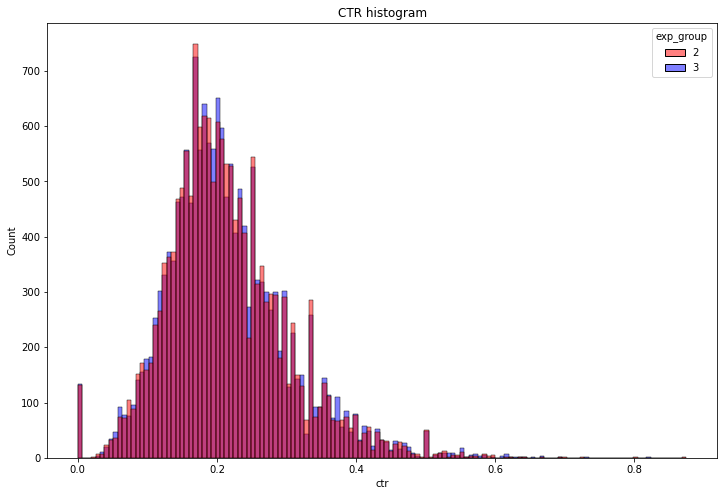

In [8]:
plt.figure(figsize=(12, 8))
sns.histplot(data=df, x='ctr', hue='exp_group', palette=['r', 'b'], alpha=0.5)
plt.title('CTR histogram');

Исходя из графика, можно сделать вывод, что распределение CTR во второй и третьей группах похоже. Однако чтобы убедиться в этом проведем симуляцию 10000 АА-тестов. Для этого сформируем подвыборки без повторения по 500 пользователей в каждой экспериментальной группе и сравним их tt-тестом на каждой итерации.

In [9]:
def get_aa_test(ctr1, ctr2, n_users=500,n_iter=10000):
    p_values = []
    for _ in range(n_iter):
        group_1 = ctr1.sample(n_users)
        group_2 = ctr2.sample(n_users)
        p_values.append(st.ttest_ind(group_1, group_2, equal_var=False)[1])
    return pd.Series(p_values)

In [10]:
p_value_aa_test = get_aa_test(df[df.exp_group ==2].ctr, df[df.exp_group ==3].ctr)

Построим гистограмму полученных 10000 p-value

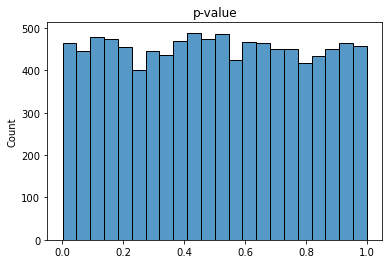

In [11]:
sns.histplot(p_value_aa_test)
plt.title('p-value');

Итак, получилось равномерное распределение p-value. Рассчитаем процент p-value, оказавшихся меньше или равных 0.05.

In [12]:
false_positive_percent = round(sum([i<=0.05 for i in p_value_aa_test])/len(p_value_aa_test)*100, 2)
print(f'Процент ошибок первого рода равен {false_positive_percent}%')

Процент ошибок первого рода равен 5.12%


**Вывод:** Процент ложноположительных срабатываний ниже принятого значения 5%, что свидетельствует о корректной работе системы сплитования